# Анализ моделей машинного обучения

## Модели:
1. Random Forest
2. SVM с линейным ядром
3. KNN
4. Логистическая регрессия

## Метрики сравнения:
- Accuracy
- Precision
- Recall
- F1-мера
- ROC-AUC
- Важность признаков

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fontTools.varLib.avar.plan import normalizeLog

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.inspection import permutation_importance

import warnings

warnings.filterwarnings('ignore')


## 1. Загрузка и подготовка данных

In [45]:
df = pd.read_csv("norm_dataframe.csv", index_col=0)
print(f"Загружено {len(df)} строк, {len(df.columns)} признаков")

target = "RESULT"
print(f"\nРаспределение классов:")
print(df[target].value_counts(normalize=True).values)

Загружено 95367 строк, 31 признаков

Распределение классов:
[0.50073925 0.49926075]


In [46]:
drop_cols = ["match_idx", "tourney_date", "PLAYER_1", "PLAYER_2"]
drop_cols = [col for col in drop_cols if col in df.columns]

df_clean = df.drop(columns=drop_cols)

X = df_clean.drop(columns=[target])
y = df_clean[target]

print(f"Размерность признаков X: {X.shape}")
print(f"Признаки: {list(X.columns)}")

Размерность признаков X: (95367, 26)
Признаки: ['ATP_POINT_DIFF', 'ATP_RANK_DIFF', 'AGE_DIFF', 'HEIGHT_DIFF', 'BEST_OF', 'DRAW_SIZE', 'H2H_DIFF', 'H2H_SURFACE_DIFF', 'DIFF_N_GAMES', 'ELO_DIFF', 'ELO_SURFACE_DIFF', 'ELO_GRAD_5_DIFF', 'ELO_GRAD_10_DIFF', 'ELO_GRAD_20_DIFF', 'ELO_GRAD_35_DIFF', 'ELO_GRAD_50_DIFF', 'ELO_GRAD_100_DIFF', 'ELO_GRAD_250_DIFF', 'P_1STIN_LAST_2000_DIFF', 'P_1STWON_LAST_2000_DIFF', 'P_2NDWON_LAST_2000_DIFF', 'P_ACE_LAST_2000_DIFF', 'P_BPSAVED_LAST_2000_DIFF', 'P_DF_LAST_2000_DIFF', 'P_SVGMS_LAST_2000_DIFF', 'P_WIN_LAST_2000_DIFF']


In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train размер: {X_train.shape[0]} ({X_train.shape[0] / len(X) * 100:.1f}%)")
print(f"Test размер: {X_test.shape[0]} ({X_test.shape[0] / len(X) * 100:.1f}%)")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train размер: 76293 (80.0%)
Test размер: 19074 (20.0%)


## 2. Обучение моделей

In [48]:
results = {}
models = {}
predictions = {}

In [49]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=30,
    min_samples_leaf=30,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

models['Random Forest'] = rf
predictions['Random Forest'] = {
    'y_pred': rf.predict(X_test),
    'y_proba': rf.predict_proba(X_test)[:, 1],
    'X_test': X_test
}

print("Random Forest обучен!")

Random Forest обучен!


In [50]:

svm_linear = SVC(
    kernel='linear',
    C=1.0,
    probability=True,
    random_state=42
)
svm_linear.fit(X_train_scaled, y_train)

models['SVM (Linear)'] = svm_linear
predictions['SVM (Linear)'] = {
    'y_pred': svm_linear.predict(X_test_scaled),
    'y_proba': svm_linear.predict_proba(X_test_scaled)[:, 1],
    'X_test': X_test_scaled
}

print("SVM (Linear) обучен!")

SVM (Linear) обучен!


In [51]:
knn = KNeighborsClassifier(n_neighbors=49)
knn.fit(X_train_scaled, y_train)

models['KNN'] = knn
predictions['KNN'] = {
    'y_pred': knn.predict(X_test_scaled),
    'y_proba': knn.predict_proba(X_test_scaled)[:, 1],
    'X_test': X_test_scaled
}

print(f"KNN обучен!")

KNN обучен!


In [52]:


logreg = LogisticRegression(
    C=0.01,
    penalty='l2',
    solver='liblinear',
    random_state=42,
    max_iter=1000
)
logreg.fit(X_train_scaled, y_train)

models['Logistic Regression'] = logreg
predictions['Logistic Regression'] = {
    'y_pred': logreg.predict(X_test_scaled),
    'y_proba': logreg.predict_proba(X_test_scaled)[:, 1],
    'X_test': X_test_scaled
}

print("Логистическая регрессия обучена!")

Логистическая регрессия обучена!


## 3. Расчет метрик качества

In [53]:
metrics_data = []

for model_name, pred_data in predictions.items():
    y_pred = pred_data['y_pred']
    y_proba = pred_data['y_proba']

    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }
    metrics_data.append(metrics)

results_df = pd.DataFrame(metrics_data)
results_df = results_df.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)

print("Сравнительная таблица метрик\n")

print(results_df.to_string(index=False))

Сравнительная таблица метрик

              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.668030   0.669500 0.661766  0.665610 0.732260
       SVM (Linear)  0.667506   0.669148 0.660716  0.664905 0.731864
      Random Forest  0.666090   0.666702 0.662291  0.664489 0.731682
                KNN  0.653193   0.654846 0.645700  0.650241 0.713651


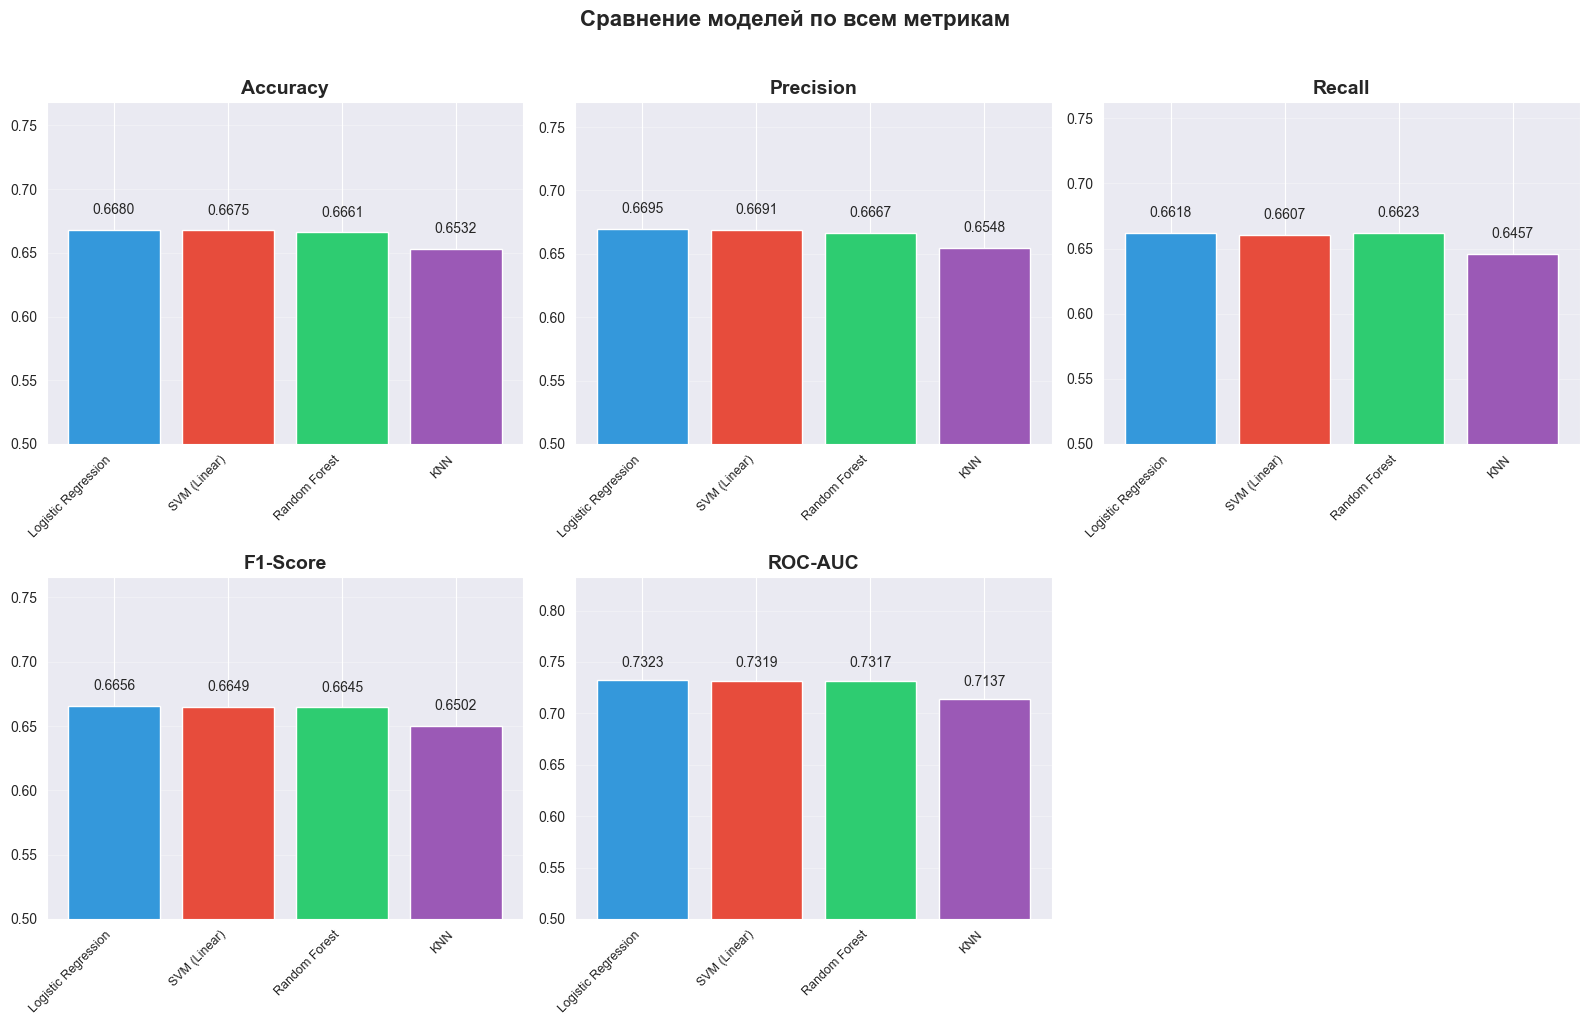

In [54]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]

    values = results_df[metric].values
    model_names = results_df['Model'].values

    bars = ax.bar(model_names, values, color=colors)
    ax.set_title(metric, fontsize=14, fontweight='bold')
    ax.set_ylim(0.5, max(values) + 0.1)
    ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=9)
    ax.grid(alpha=0.3, axis='y')

    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2., val + 0.01,
                f'{val:.4f}', ha='center', va='bottom', fontsize=10)

axes[1, 2].axis('off')

plt.suptitle('Сравнение моделей по всем метрикам', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 4. ROC-кривые

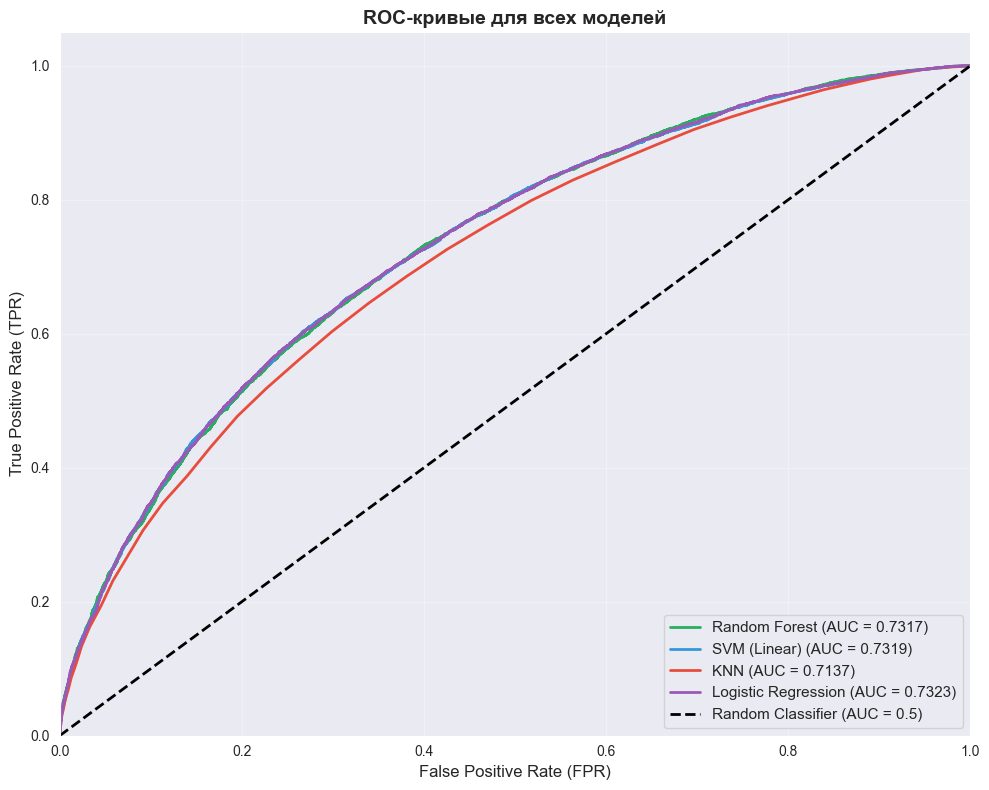

In [55]:
plt.figure(figsize=(10, 8))

colors = ['#27ae60', '#3498db', '#e74c3c', '#9b59b6']

for (model_name, pred_data), color in zip(predictions.items(), colors):
    y_proba = pred_data['y_proba']
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{model_name} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC-кривые для всех моделей', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Матрицы ошибок

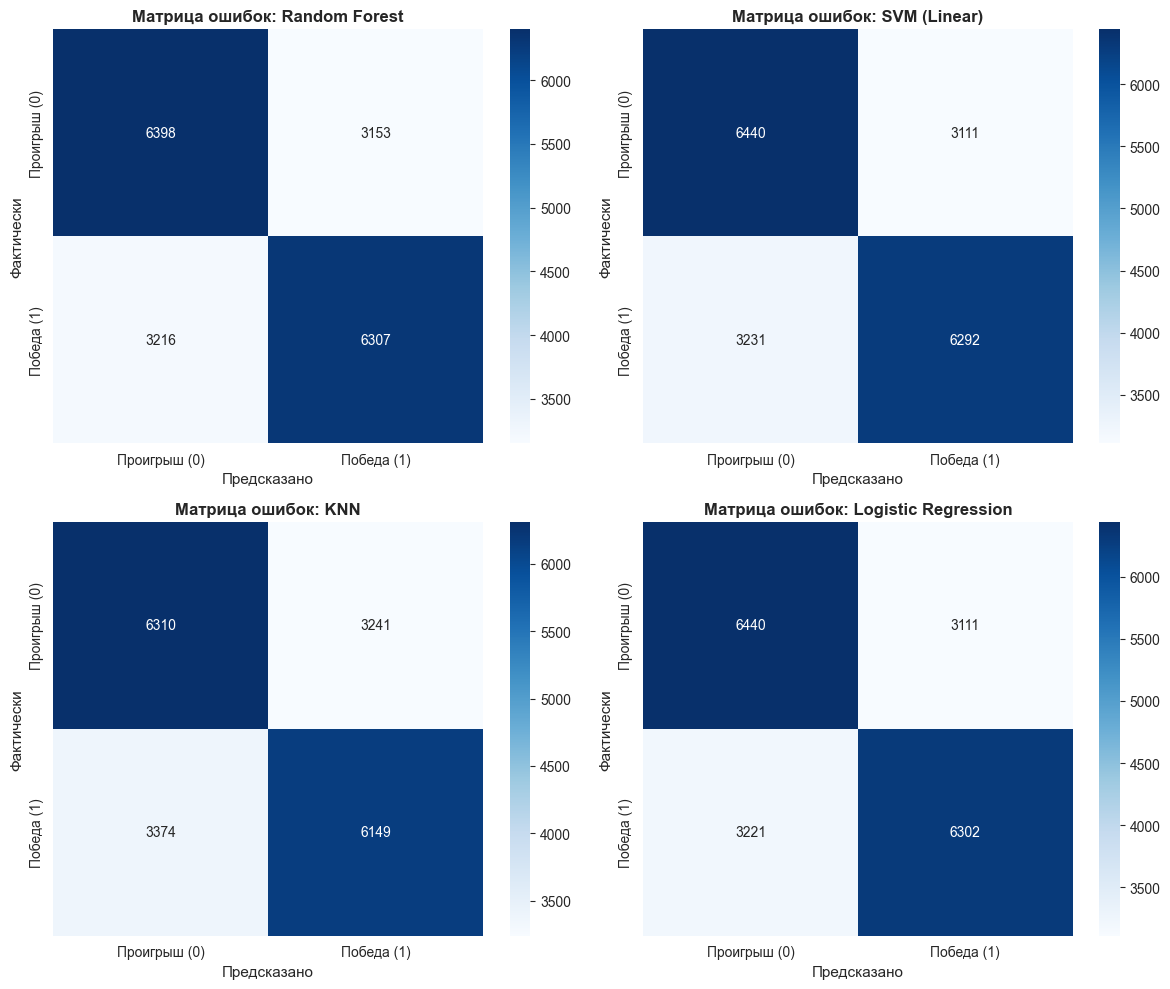

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (model_name, pred_data) in zip(axes.flatten(), predictions.items()):
    y_pred = pred_data['y_pred']
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Проигрыш (0)', 'Победа (1)'],
                yticklabels=['Проигрыш (0)', 'Победа (1)'])
    ax.set_xlabel('Предсказано', fontsize=11)
    ax.set_ylabel('Фактически', fontsize=11)
    ax.set_title(f'Матрица ошибок: {model_name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Важность признаков

ВАЖНОСТЬ ПРИЗНАКОВ - RANDOM FOREST

Топ-15 важных признаков (Random Forest):
                 Feature  Importance
                ELO_DIFF    0.168707
        ELO_SURFACE_DIFF    0.165191
          ATP_POINT_DIFF    0.111268
           ATP_RANK_DIFF    0.103687
    P_WIN_LAST_2000_DIFF    0.072734
            DIFF_N_GAMES    0.041495
                AGE_DIFF    0.034395
P_BPSAVED_LAST_2000_DIFF    0.033693
 P_1STWON_LAST_2000_DIFF    0.023409
    P_ACE_LAST_2000_DIFF    0.022908
     P_DF_LAST_2000_DIFF    0.022223
         ELO_GRAD_5_DIFF    0.021894
  P_SVGMS_LAST_2000_DIFF    0.021115
 P_2NDWON_LAST_2000_DIFF    0.020891
        ELO_GRAD_10_DIFF    0.020796


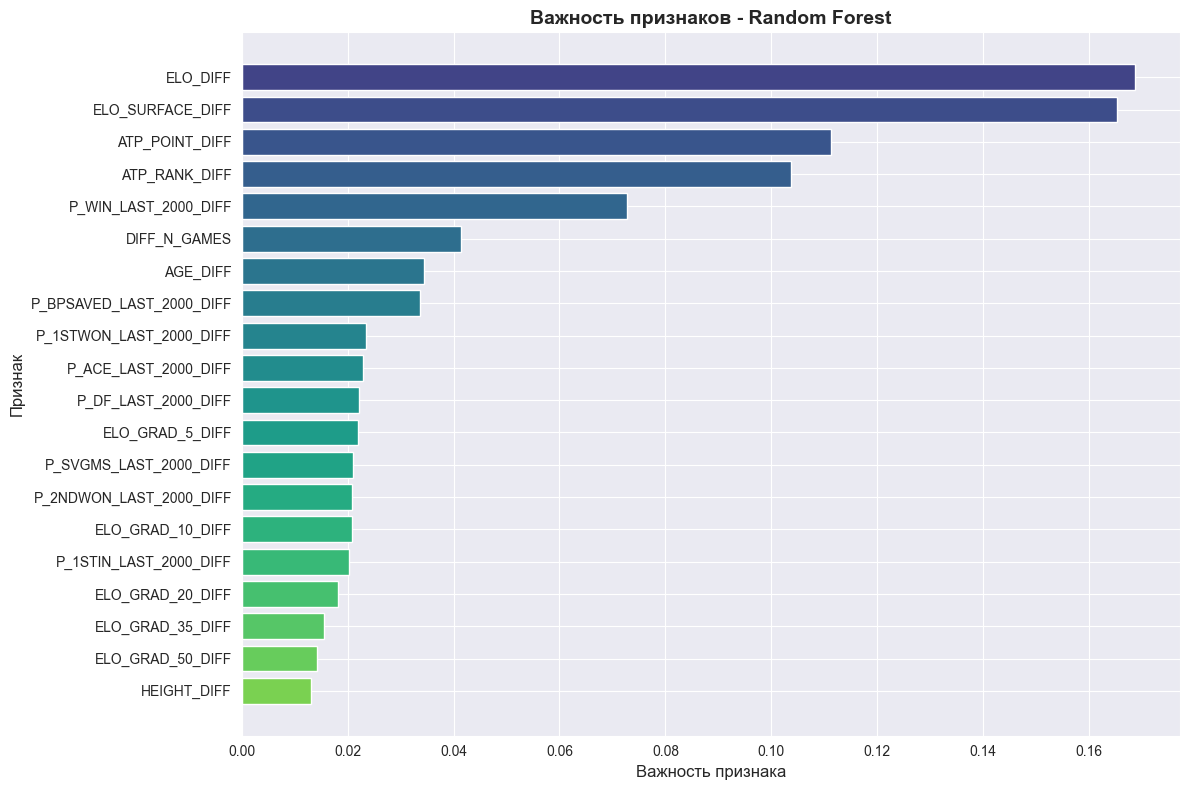

In [57]:
print("=" * 60)
print("ВАЖНОСТЬ ПРИЗНАКОВ - RANDOM FOREST")
print("=" * 60)

rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': models['Random Forest'].feature_importances_
}).sort_values('Importance', ascending=False)

print("\nТоп-15 важных признаков (Random Forest):")
print(rf_importance.head(15).to_string(index=False))

plt.figure(figsize=(12, 8))
top_rf = rf_importance.head(20)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_rf)))
plt.barh(top_rf['Feature'], top_rf['Importance'], color=colors)
plt.xlabel('Важность признака', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.title('Важность признаков - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

ВАЖНОСТЬ ПРИЗНАКОВ - ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

Топ-15 важных признаков (Логистическая регрессия):
                 Feature  Importance
        ELO_SURFACE_DIFF    0.220242
                ELO_DIFF    0.187374
           ATP_RANK_DIFF    0.119086
                AGE_DIFF    0.107326
 P_1STWON_LAST_2000_DIFF    0.055615
          ATP_POINT_DIFF    0.044521
            DIFF_N_GAMES    0.034409
  P_1STIN_LAST_2000_DIFF    0.024662
        ELO_GRAD_50_DIFF    0.022764
    P_WIN_LAST_2000_DIFF    0.022196
P_BPSAVED_LAST_2000_DIFF    0.020353
       ELO_GRAD_100_DIFF    0.018874
                H2H_DIFF    0.018830
     P_DF_LAST_2000_DIFF    0.014229
         ELO_GRAD_5_DIFF    0.013054


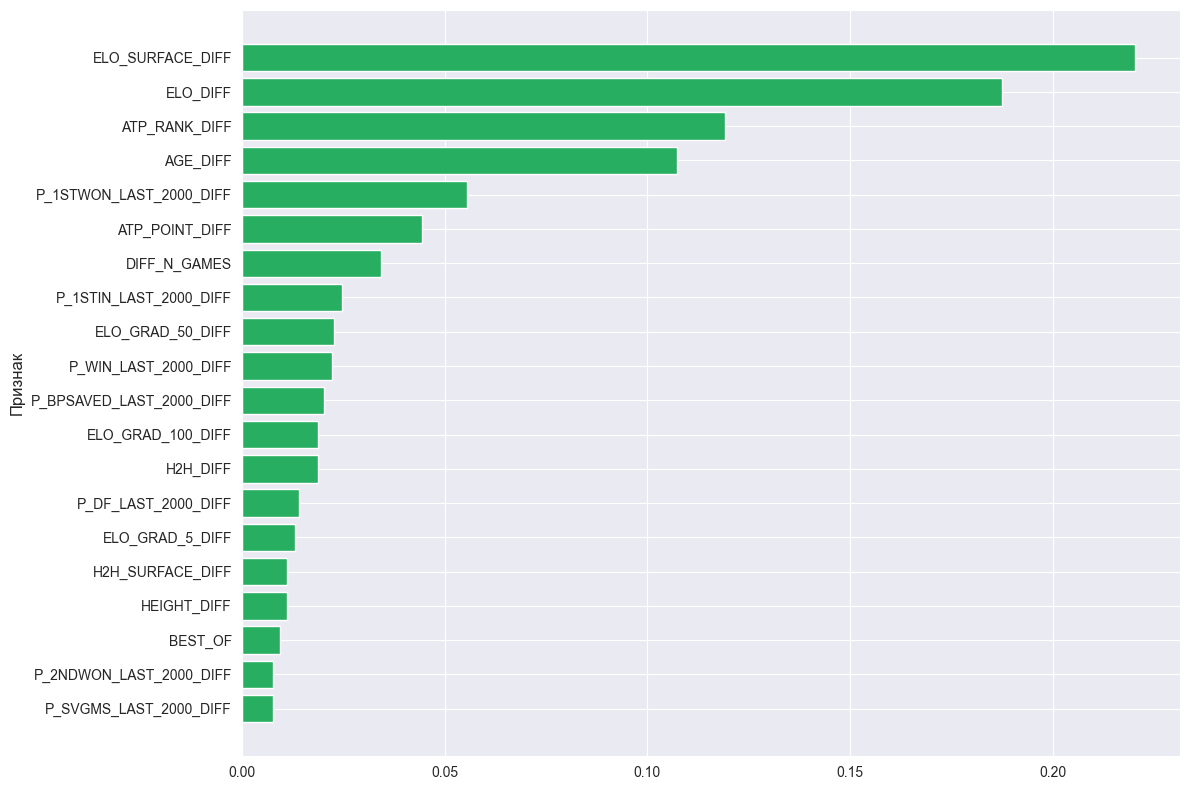

In [58]:
print("=" * 60)
print("ВАЖНОСТЬ ПРИЗНАКОВ - ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ")
print("=" * 60)

logreg_coefs = models['Logistic Regression'].coef_[0]
logreg_coefs_abs_sum = sum(map(abs, logreg_coefs))

logreg_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': [abs(c) / logreg_coefs_abs_sum for c in logreg_coefs],
}).sort_values('Importance', ascending=False)

print("\nТоп-15 важных признаков (Логистическая регрессия):")
print(logreg_importance[['Feature', 'Importance']].head(15).to_string(index=False))

plt.figure(figsize=(12, 8))
top_logreg = logreg_importance.head(20)
colors = ['#27ae60' if c > 0 else '#e74c3c' for c in top_logreg['Importance']]
plt.barh(top_logreg['Feature'], top_logreg['Importance'], color=colors)
plt.ylabel('Признак', fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

ВАЖНОСТЬ ПРИЗНАКОВ - SVM (LINEAR)

Топ-15 важных признаков (SVM Linear):
                 Feature  Importance
                ELO_DIFF    0.201015
        ELO_SURFACE_DIFF    0.183495
           ATP_RANK_DIFF    0.121985
                AGE_DIFF    0.103917
 P_1STWON_LAST_2000_DIFF    0.083058
  P_1STIN_LAST_2000_DIFF    0.043515
            DIFF_N_GAMES    0.035452
          ATP_POINT_DIFF    0.024458
                H2H_DIFF    0.021779
        ELO_GRAD_50_DIFF    0.021135
P_BPSAVED_LAST_2000_DIFF    0.018572
    P_ACE_LAST_2000_DIFF    0.016652
         ELO_GRAD_5_DIFF    0.013763
     P_DF_LAST_2000_DIFF    0.013544
       ELO_GRAD_100_DIFF    0.013307


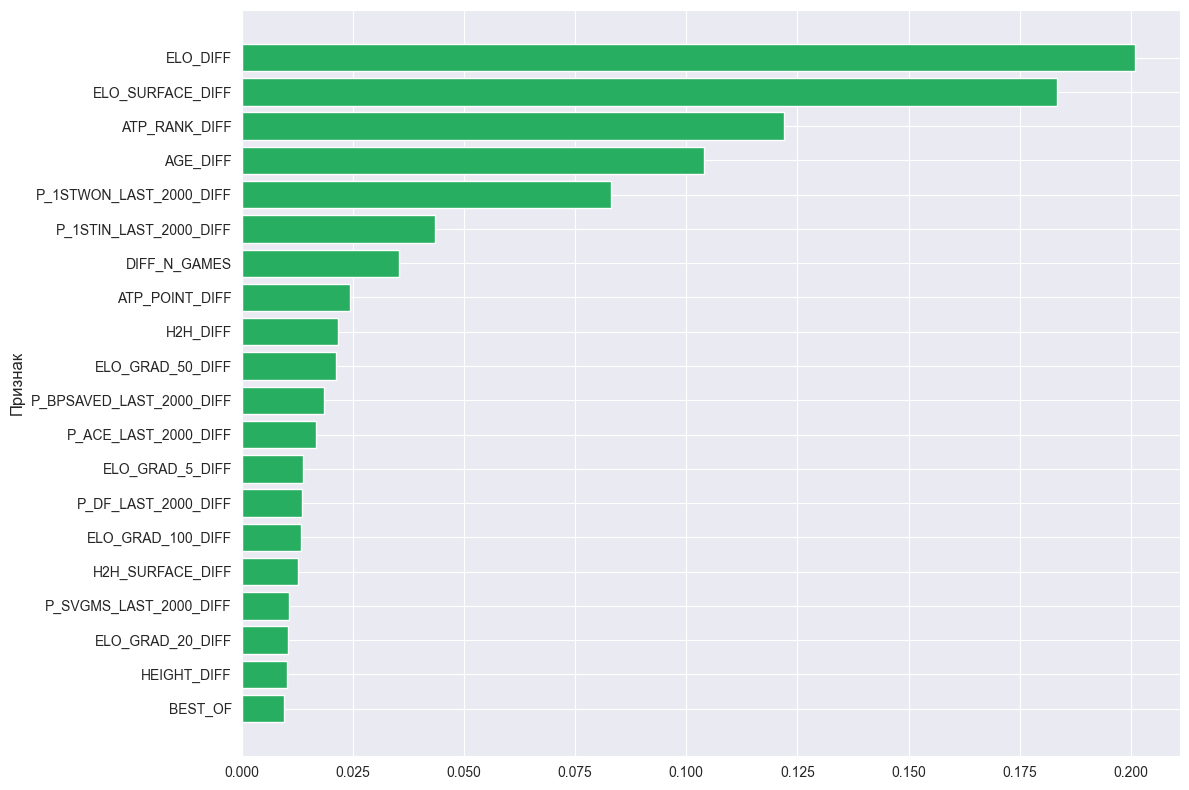

In [60]:
print("=" * 60)
print("ВАЖНОСТЬ ПРИЗНАКОВ - SVM (LINEAR)")
print("=" * 60)

svm_coefs = models['SVM (Linear)'].coef_[0]
svm_coefs_abs_sum = sum(map(abs, svm_coefs))

svm_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': [abs(c) / svm_coefs_abs_sum for c in svm_coefs],

}).sort_values('Importance', ascending=False)

print("\nТоп-15 важных признаков (SVM Linear):")
print(svm_importance[['Feature', 'Importance']].head(15).to_string(index=False))

plt.figure(figsize=(12, 8))
top_svm = svm_importance.head(20)
colors = ['#27ae60' if c > 0 else '#e74c3c' for c in top_svm['Importance']]
plt.barh(top_svm['Feature'], top_svm['Importance'], color=colors)
plt.ylabel('Признак', fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

ВАЖНОСТЬ ПРИЗНАКОВ - KNN
0.9999999999999999

Топ-15 важных признаков (KNN):
                 Feature  Importance
        ELO_SURFACE_DIFF    0.249821
                ELO_DIFF    0.196535
           ATP_RANK_DIFF    0.157914
    P_WIN_LAST_2000_DIFF    0.083922
          ATP_POINT_DIFF    0.074045
                AGE_DIFF    0.046151
                 BEST_OF    0.026678
            DIFF_N_GAMES    0.025127
    P_ACE_LAST_2000_DIFF    0.017747
        ELO_GRAD_35_DIFF    0.015516
     P_DF_LAST_2000_DIFF    0.013770
  P_SVGMS_LAST_2000_DIFF    0.013052
             HEIGHT_DIFF    0.011259
P_BPSAVED_LAST_2000_DIFF    0.010719
        ELO_GRAD_20_DIFF    0.009862


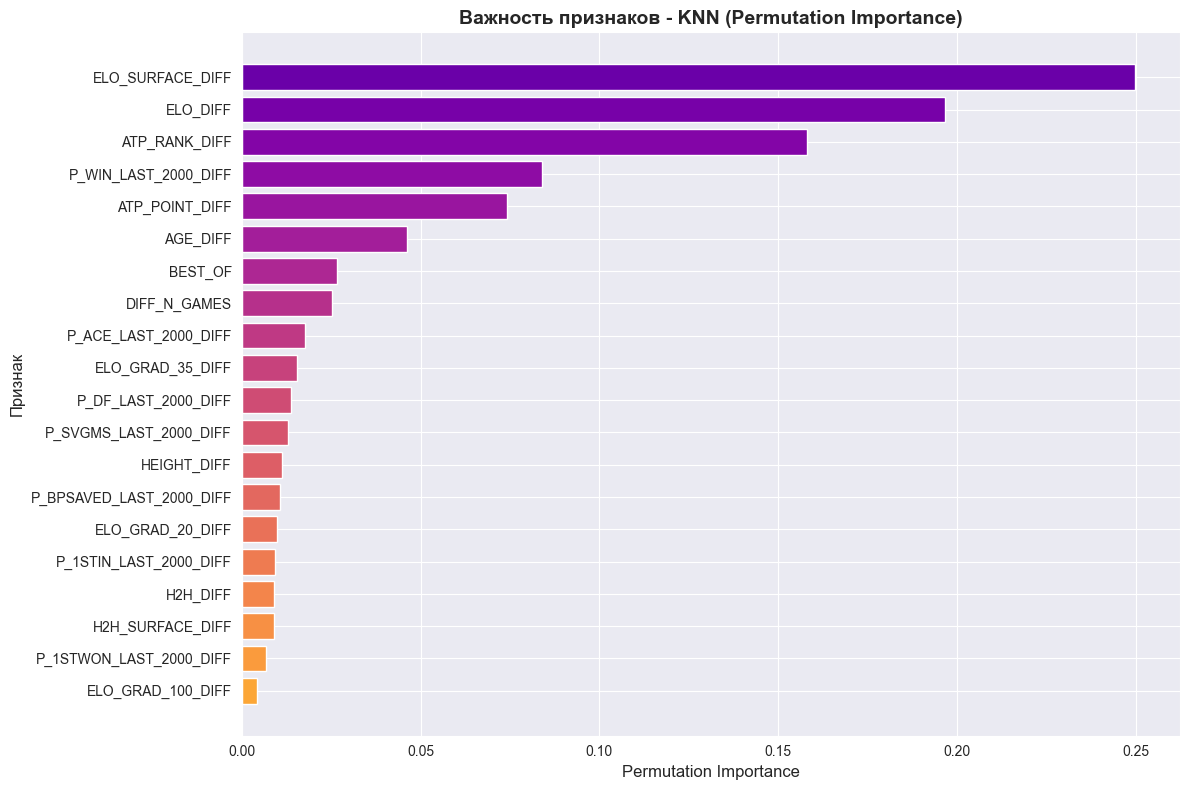

In [61]:
print("=" * 60)
print("ВАЖНОСТЬ ПРИЗНАКОВ - KNN")
print("=" * 60)

perm_importance = permutation_importance(
    models['KNN'], X_test_scaled, y_test,
    n_repeats=10, random_state=42, n_jobs=-1, scoring='roc_auc'
)

importance_coefs_sum = sum(map(abs, perm_importance.importances_mean))

normalized_importance_means = [abs(c) / importance_coefs_sum for c in perm_importance.importances_mean]

knn_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': normalized_importance_means,
}).sort_values('Importance', ascending=False)

print(sum(knn_importance["Importance"]))

print("\nТоп-15 важных признаков (KNN):")
print(knn_importance.head(15).to_string(index=False))

plt.figure(figsize=(12, 8))
top_knn = knn_importance.head(20)
colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(top_knn)))
plt.barh(top_knn['Feature'], top_knn['Importance'], color=colors, capsize=3)
plt.xlabel('Permutation Importance', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.title('Важность признаков - KNN (Permutation Importance)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Сравнение важности признаков в разных моделях

In [66]:
importance_comparison = pd.DataFrame({
    'Feature': X.columns,
    'Random Forest': rf_importance["Importance"],
    'Logistic Regression': logreg_importance["Importance"],
    'SVM (Linear)': svm_importance["Importance"],
    'KNN (Permutation)': knn_importance["Importance"]
})

importance_comparison['Mean'] = importance_comparison[['Random Forest', 'Logistic Regression',
                                                       'SVM (Linear)', 'KNN (Permutation)']].mean(axis=1)

importance_comparison = importance_comparison.sort_values('Mean', ascending=False)


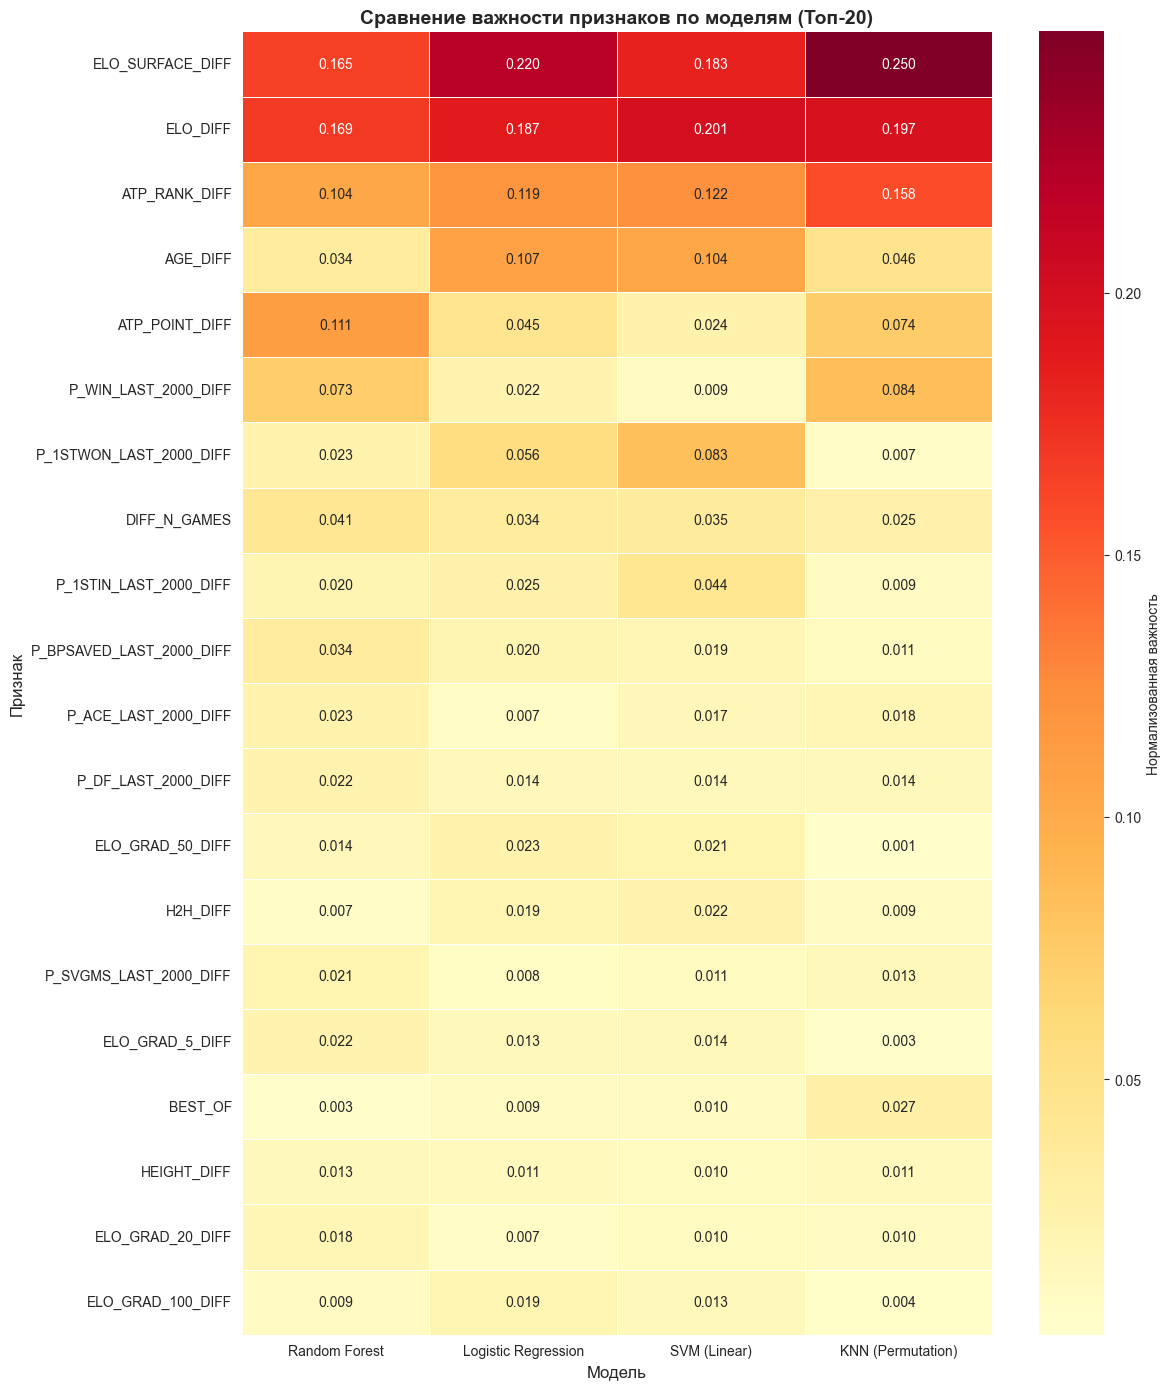

In [67]:
plt.figure(figsize=(12, 14))

top_features = importance_comparison.head(20)

heatmap_data = top_features[['Random Forest', 'Logistic Regression', 'SVM (Linear)', 'KNN (Permutation)']]
heatmap_data.index = top_features['Feature']

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd',
            linewidths=0.5, cbar_kws={'label': 'Нормализованная важность'})
plt.title('Сравнение важности признаков по моделям (Топ-20)', fontsize=14, fontweight='bold')
plt.xlabel('Модель', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.tight_layout()
plt.show()

## Выводы

In [68]:
print("1. МЕТРИКИ КАЧЕСТВА (отсортировано по ROC-AUC):\n")
print(results_df.to_string(index=False))

best_model = results_df.iloc[0]
print(f"\n2. ЛУЧШАЯ МОДЕЛЬ: {best_model['Model']}")

print("\n3. ТОП-5 НАИБОЛЕЕ ВАЖНЫХ ПРИЗНАКОВ (по средней важности):\n")

for i, row in importance_comparison.head(5).iterrows():
    print(f"    {importance_comparison.head(5).index.get_loc(i) + 1}. {row['Feature']} (средняя важность: {row['Mean']:.4f})")

1. МЕТРИКИ КАЧЕСТВА (отсортировано по ROC-AUC):

              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.668030   0.669500 0.661766  0.665610 0.732260
       SVM (Linear)  0.667506   0.669148 0.660716  0.664905 0.731864
      Random Forest  0.666090   0.666702 0.662291  0.664489 0.731682
                KNN  0.653193   0.654846 0.645700  0.650241 0.713651

2. ЛУЧШАЯ МОДЕЛЬ: Logistic Regression

3. ТОП-5 НАИБОЛЕЕ ВАЖНЫХ ПРИЗНАКОВ (по средней важности):

    1. ELO_SURFACE_DIFF (средняя важность: 0.2047)
    2. ELO_DIFF (средняя важность: 0.1884)
    3. ATP_RANK_DIFF (средняя важность: 0.1257)
    4. AGE_DIFF (средняя важность: 0.0729)
    5. ATP_POINT_DIFF (средняя важность: 0.0636)


## Выводы

### Сравнение моделей:

1. **По ROC-AUC (ключевая метрика)**:
   - Все модели показывают схожие результаты (~0.71-0.73)
   - Линейные модели (Логистическая регрессия, SVM Linear) демонстрируют наиболее стабильные результаты

2. **По Accuracy**:
   - Модели достигают точности ~66-67%
   - Это немного лучше случайного угадывания (50%)

3. **По Precision/Recall/F1**:
   - Метрики сбалансированы (Precision ~ Recall), так как датасет сбалансирован

### Важность признаков:

1. **Наиболее важные признаки**:
   - ELO_DIFF - разница в рейтингах ELO
   - ELO_SURFACE_DIFF - разница в рейтингах ELO на конкретном покрытии
   - ATP_RANK_DIFF - разница в ATP ранге

